In [1]:
%load_ext autoreload
%autoreload 2

# Set CUDA_VISIBLE_DEVICES

import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

# matplotlib setting
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (8, 8)
plt.rcParams["font.size"] = 14
%matplotlib inline

import numpy as np
import torch
import pytorch_lightning as pl
import pickle
from tqdm import tqdm

from plt_model import LitModel
import torch.nn.functional as F

/home/pedram/miniconda3/envs/echo-llm/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import argparse
import torch
import numpy as np
import random
import pytorch_lightning as pl
import pickle
from tqdm import tqdm
import os
#from torchmetrics import CatMetric, MetricCollection, MetricTracker
from datasets import load_dataset

from transformers import AutoTokenizer
from transformers import AutoModel, AutoModelForSeq2SeqLM, AutoConfig, AutoModelForMaskedLM, AutoModelForCausalLM, default_data_collator
from pytorch_lightning.callbacks import ModelCheckpoint


from plt_model import LitModel
from dataset import prepare_data, preprocess_datasets, MixedDataset
from pydantic import BaseModel

import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
class Config(BaseModel):
    tag_model: str = 'facebook/opt-125m'
    loss_type: str = 'baseline'
    load_name: str = None
    save_name: str = None
    saveperplexities: str = None
    eval_only: bool = False
    evalgen_only: bool = False
    optimizer: str = 'adam'
    focal_gamma: float = None
    focal_alpha: float = None
    learning_rate: float = 2e-5
    max_epochs: int = 5
    block_size: int = 64
    batch_size: int = 128
    debug: bool = False
    seed: int = 0
    num_workers: int = 127
    num_devices: int = 1
    accelerator: str = "auto"
    strategy: str = 'ddp'
    pretrained: bool = False
    version_name: str = None
    generate: str = None
    load_generate: str = None
    original_dataset_fraction: float = 0.0
    accumulate_grad_batches: int = 1
    generated_length: int = 64
    evaluate_KT: str = "kt_dataset_full.json"
    blimp_eval: list = ['adjunct_island', 'causative']
    dataset_fractions: int = 1
    stage: int = 1
    access_token: str = "/home/pedram/echo-llm/huggingface_token.txt"
    test_mode: bool = False
    tags: list = []
    task: str = "wikitext"
    
    class Config:
        extra = "forbid"


In [4]:
def get_probability_of_correct_class(logits, labels,):
    shift_logits = logits[..., :-1, :].contiguous()
    shift_labels = labels[..., 1:].contiguous()
    log_probs = F.log_softmax(shift_logits, dim=-1)
    log_p_t = log_probs.gather(dim=-1, index=shift_labels.unsqueeze(-1)).squeeze(-1)
    return log_p_t.exp()
    

def get_loss_distribution(model, dataset):
    model.to(device)
    losses = []
    for batch in tqdm(dataset):
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(batch['input_ids'].unsqueeze(0), labels=batch['input_ids'].unsqueeze(0))
        loss = outputs.loss
        losses.append(loss.item())
    return losses

def get_prob_distribution(model, dataset):
    model.to(device)
    probs = []
    for batch in tqdm(dataset):
        batch = {k: torch.as_tensor(v, device=device) for k, v in batch.items()}
        outputs = model(batch['input_ids'].unsqueeze(0), labels=batch['input_ids'].unsqueeze(0))
        logits = outputs.logits
        labels = batch['input_ids'].unsqueeze(0)
        prob = get_probability_of_correct_class(logits, labels)
        probs.append(prob.mean().item())
    return probs

In [5]:
model_tag = "meta-llama/Llama-3.2-1B"
batch_size = 16
block_size = 512
num_devices = 1
accumulate_grad_batches = 4
num_workers = 127
seed = 10
access_token = "../huggingface_token.txt"

task = "wikitext"
scale = 0


In [6]:
random.seed(seed)
torch.manual_seed(seed)
np.random.seed(seed)
pl.seed_everything(seed)

Seed set to 10


10

In [7]:
if access_token is not None or not os.path.exists(access_token):
    with open(access_token, "r") as f:
        token = f.read().strip()
else:
    token = None
model_original = AutoModelForCausalLM.from_pretrained(model_tag, cache_dir='./model_cache_dir', token=token)
model_original.to(device)

LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(128256, 2048)
    (layers): ModuleList(
      (0-15): 16 x LlamaDecoderLayer(
        (self_attn): LlamaSdpaAttention(
          (q_proj): Linear(in_features=2048, out_features=2048, bias=False)
          (k_proj): Linear(in_features=2048, out_features=512, bias=False)
          (v_proj): Linear(in_features=2048, out_features=512, bias=False)
          (o_proj): Linear(in_features=2048, out_features=2048, bias=False)
          (rotary_emb): LlamaRotaryEmbedding()
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear(in_features=2048, out_features=8192, bias=False)
          (up_proj): Linear(in_features=2048, out_features=8192, bias=False)
          (down_proj): Linear(in_features=8192, out_features=2048, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): LlamaRMSNorm((2048,), eps=1e-05)
        (post_attention_layernorm): LlamaRMSNorm((2048,), eps=1e-05)
      )
    )
    (norm):

In [8]:
tokenizer = AutoTokenizer.from_pretrained(model_tag,
                                          cache_dir='./model_cache_dir',
                                          return_dict=True,
                                          token=token,)
tokenizer.pad_token = tokenizer.eos_token

In [9]:
raw_dataset = prepare_data()
dataset = preprocess_datasets(raw_dataset, tokenizer, block_size=block_size, task="wikitext")

Dataset already downloaded and processed


Running tokenizer on dataset (num_proc=4): 100%|██████████| 3760/3760 [00:02<00:00, 1832.85 examples/s]

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'attention_mask'],
        num_rows: 36718
    })
    validation: Dataset({
        features: ['input_ids', 'attention_mask'],
        num_rows: 3760
    })
})
Grouping texts in chunks of 512



(Preprocess datasets) Grouping texts in chunks of 512 for wikitext (num_proc=4): 100%|██████████| 36718/36718 [00:01<00:00, 21197.42 examples/s]
(Preprocess datasets) Grouping texts in chunks of 512 for wikitext (num_proc=4): 100%|██████████| 3760/3760 [00:00<00:00, 9519.11 examples/s]


In [ ]:
load_generate = "/scr/echollm/generated_datasets/llama-1b/focal_2.0/frac_6/batch64-lr2e-5-seed10-20250303214049/"
stage = 0
dataset_fractions = 6

train_datasets = [dataset["train"]]
for i in range(0, 3):
    train_datasets.append(MixedDataset(generated_dataset_folder=load_generate,
                                      original_dataset=dataset,
                                      experiment_stage=i,
                                      fractions=dataset_fractions,
                                      block_size=block_size,
                                      partition='train',
                                      tokenizer=tokenizer,
                                      task=task,
                                      scale=scale,)
                                    )

^^^^^^^^^^^^^^^^^^^^^^^^^ File /scr/echollm/generated_datasets/llama-1b/focal_2.0/frac_6/batch64-lr2e-5-seed10-20250303214049/stage-1.txt not found ^^^^^^^^^^^^^^^^^^^^^^^^^
generated_dataset num_rows 0
original_dataset num_rows 4808
fractioned_dataset num_rows 801
Dataset({
    features: ['input_ids', 'attention_mask', 'labels'],
    num_rows: 0
})
train_dataset num_rows 801
Dataset({
    features: ['input_ids', 'attention_mask', 'labels'],
    num_rows: 801
})


Running tokenizer on dataset (num_proc=4): 100%|██████████| 3202/3202 [00:02<00:00, 1433.46 examples/s]


DatasetDict({
    train: Dataset({
        features: ['input_ids', 'attention_mask'],
        num_rows: 3202
    })
})
Grouping texts in chunks of 64


(Preprocess datasets) Grouping texts in chunks of 64 for wikitext (num_proc=4): 100%|██████████| 3202/3202 [00:00<00:00, 5643.46 examples/s]


generated_dataset num_rows 6407
original_dataset num_rows 4808
fractioned_dataset num_rows 801
Dataset({
    features: ['input_ids', 'attention_mask', 'labels'],
    num_rows: 6407
})
train_dataset num_rows 7208
Dataset({
    features: ['input_ids', 'attention_mask', 'labels'],
    num_rows: 7208
})


Running tokenizer on dataset (num_proc=4): 100%|██████████| 3148/3148 [00:03<00:00, 926.76 examples/s] 


DatasetDict({
    train: Dataset({
        features: ['input_ids', 'attention_mask'],
        num_rows: 3148
    })
})
Grouping texts in chunks of 64


(Preprocess datasets) Grouping texts in chunks of 64 for wikitext (num_proc=4): 100%|██████████| 3148/3148 [00:01<00:00, 2636.95 examples/s]


generated_dataset num_rows 12809
original_dataset num_rows 4808
fractioned_dataset num_rows 801
Dataset({
    features: ['input_ids', 'attention_mask', 'labels'],
    num_rows: 12809
})
train_dataset num_rows 13610
Dataset({
    features: ['input_ids', 'attention_mask', 'labels'],
    num_rows: 13610
})


(MixedDataset) Grouping texts in chunks of 512: 100%|██████████| 13610/13610 [00:02<00:00, 4981.20 examples/s]


In [11]:
models = [model_original]
for i in range(3):
    load_name = f"/scr/echollm/checkpoints/focal_2.0/frac6/meta-llama/Llama-3.2-1B/M{i}-llama1b-batch64-lr2e-05-gamma2.0-seed10_20250303214049/last.ckpt"
    model = LitModel.load_from_checkpoint(load_name, model=model_original, tokenizer=tokenizer)
    model = model.model
    model.to(device)
    models.append(model)

/home/pedram/miniconda3/envs/echo-llm/lib/python3.12/site-packages/pytorch_lightning/utilities/parsing.py:208: Attribute 'cml_model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['cml_model'])`.
/home/pedram/miniconda3/envs/echo-llm/lib/python3.12/site-packages/pytorch_lightning/utilities/parsing.py:208: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.


In [12]:
losses = []
for model in models:
    results = []
    for data in train_datasets:
        res = []
        for batch in tqdm(data):
            batch = {k: torch.as_tensor(v, device=device) for k, v in batch.items()}
            outputs = model(batch['input_ids'].unsqueeze(0), labels=batch['input_ids'].unsqueeze(0))
            loss = outputs.loss
            res.append(loss.item())
        results.append(res)
    losses.append(results)


100%|██████████| 2402/2402 [03:26<00:00, 11.62it/s]


In [13]:
probs = []
for model in models:
    results = []
    for data in train_datasets:
        res = get_prob_distribution(model, data)
        results.append(res)
    probs.append(results)

100%|██████████| 2402/2402 [03:30<00:00, 11.40it/s]


In [1]:
import pickle

losses = pickle.load(open("losses.pkl", "rb"))
probs = pickle.load(open("probs.pkl", "rb"))

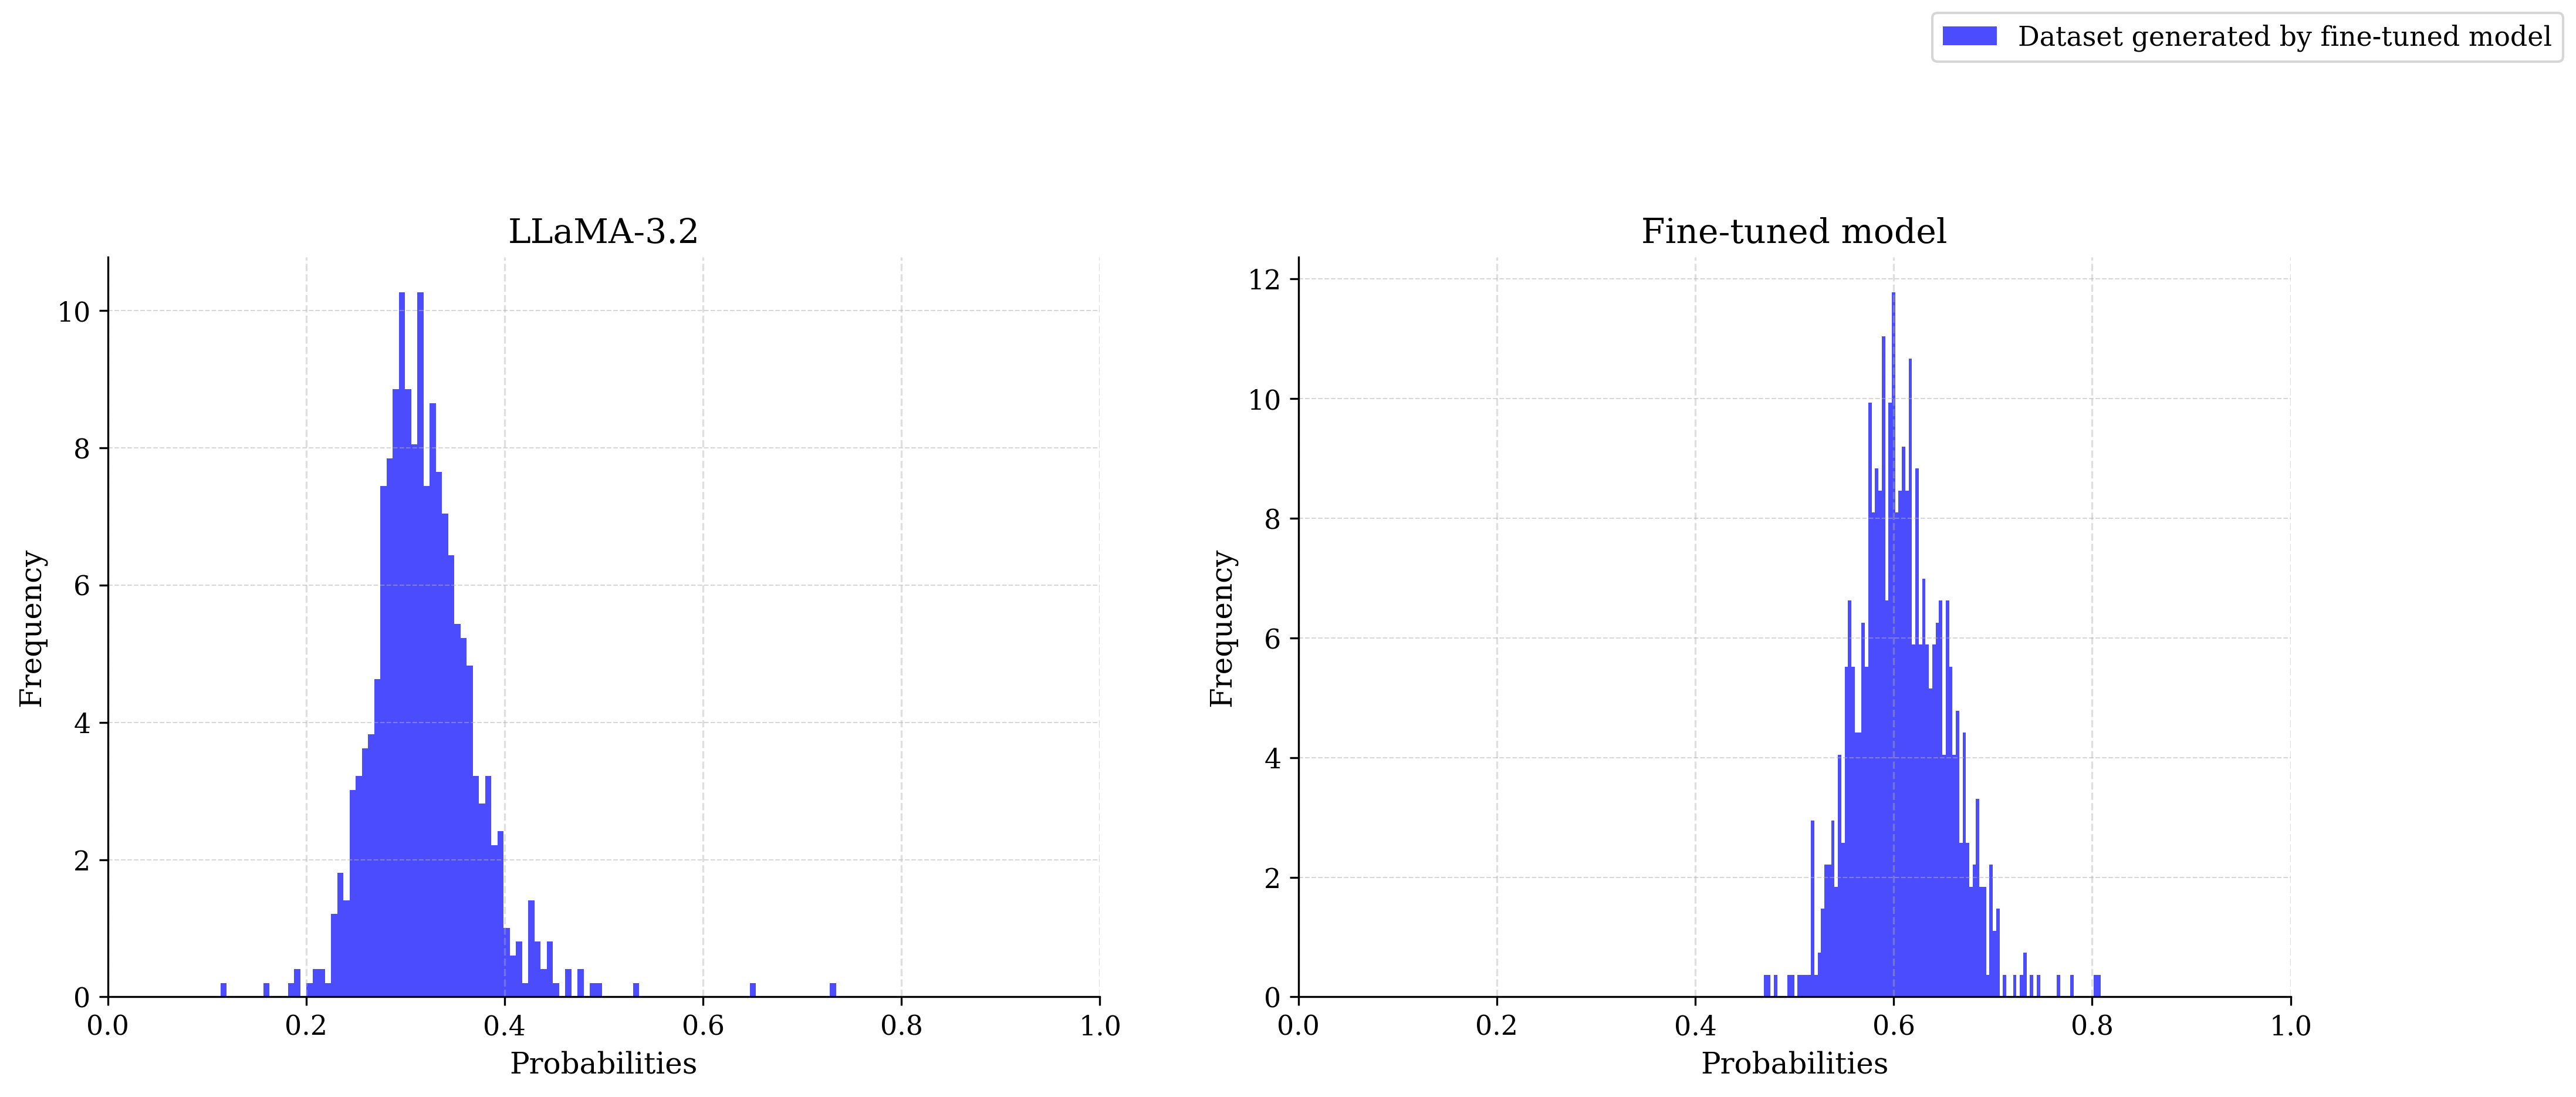

In [2]:
import matplotlib.pyplot as plt
# import scienceplots
import numpy as np

# plt.style.use(['science', 'nature'])

# Assuming data_ind can range from 0 to N-1
N = 2  # Number of data indices
rows = 2  # Number of rows in the grid
cols = (N + 2) // rows  # Number of columns in the grid

# Set global plot settings for publication quality
# Nature-style plot aesthetics
plt.rcParams.update({
    "font.family": "serif",
    "font.size": 12,
    "axes.labelsize": 14,
    "axes.titlesize": 14,
    "legend.fontsize": 11,
    "xtick.labelsize": 11,
    "ytick.labelsize": 11,
    "figure.dpi": 300,
    "lines.linewidth": 2,
    "axes.spines.top": False,
    "axes.spines.right": False,
    "axes.grid": True,
    "grid.alpha": 0.4,
    "grid.linestyle": "--",
})

fig, axes = plt.subplots(rows, cols, figsize=(16, 12))
axes = axes.flatten()  # Flatten the 2D array of axes for easy iteration
names = ['WikiText', 'Dataset generated by fine-tuned model', "3", "4"]

handles = []
labels = []

for modelz_ind in range(2):
    ax = axes[modelz_ind]

    for j in range(1, 2):
        # Plot the loss distribution for each model
        hist = ax.hist(probs[modelz_ind][j], bins=100, alpha=0.7, density=True, color='blue')
    
    # ax.hist(probs[modelz_ind][0], bins=100, alpha=0.7)
    # ax.hist(probs[modelz_ind][1], bins=100, alpha=0.7)
    # ax.hist(probs[modelz_ind][2], bins=100, alpha=0.7)
    # ax.hist(probs[modelz_ind][3], bins=100, alpha=0.7)
        if modelz_ind == N - 1:  # only do this in the last subplot
            handles.append(hist[2][0])  # hist[2] is a list of Patch objects
            labels.append(names[j])
    # ax.hist(probs[modelz_ind][3][-len(probs[modelz_ind][3]) // 4:], bins=100, edgecolor='black', alpha=0.7, density=True)
    if modelz_ind == 0:
        ax.set_title('LLaMA-3.2', fontsize=14)
    else:
        ax.set_title("Fine-tuned model", fontsize=14)
    ax.set_xlabel('Probabilities', fontsize=12)
    ax.set_ylabel('Frequency', fontsize=12)
    ax.set_xlim(0, 1)  # Set x-axis limits to [0, 1]
    # ax.grid(axis='y', linestyle='--', alpha=0.7)
    # Optional grid
    # ax.legend(names[modelz_ind], fontsize=14, loc='upper right')

    ax.grid(True, linestyle='--', linewidth=0.5, alpha=0.5, axis='y')

# Remove any unused subplots
for i in range(N, len(axes)):
    fig.delaxes(axes[i])

fig.legend(handles, labels, loc='upper right')
# fig.suptitle('Histogram of Probabilities Predicted by Models on Datasets', fontsize=16)
# plt.tight_layout(rect=[0, 0, 1, 0.96])

# Saving the SVG
# plt.savefig("probabilities_distribution.svg", format='svg', bbox_inches='tight')

plt.show()

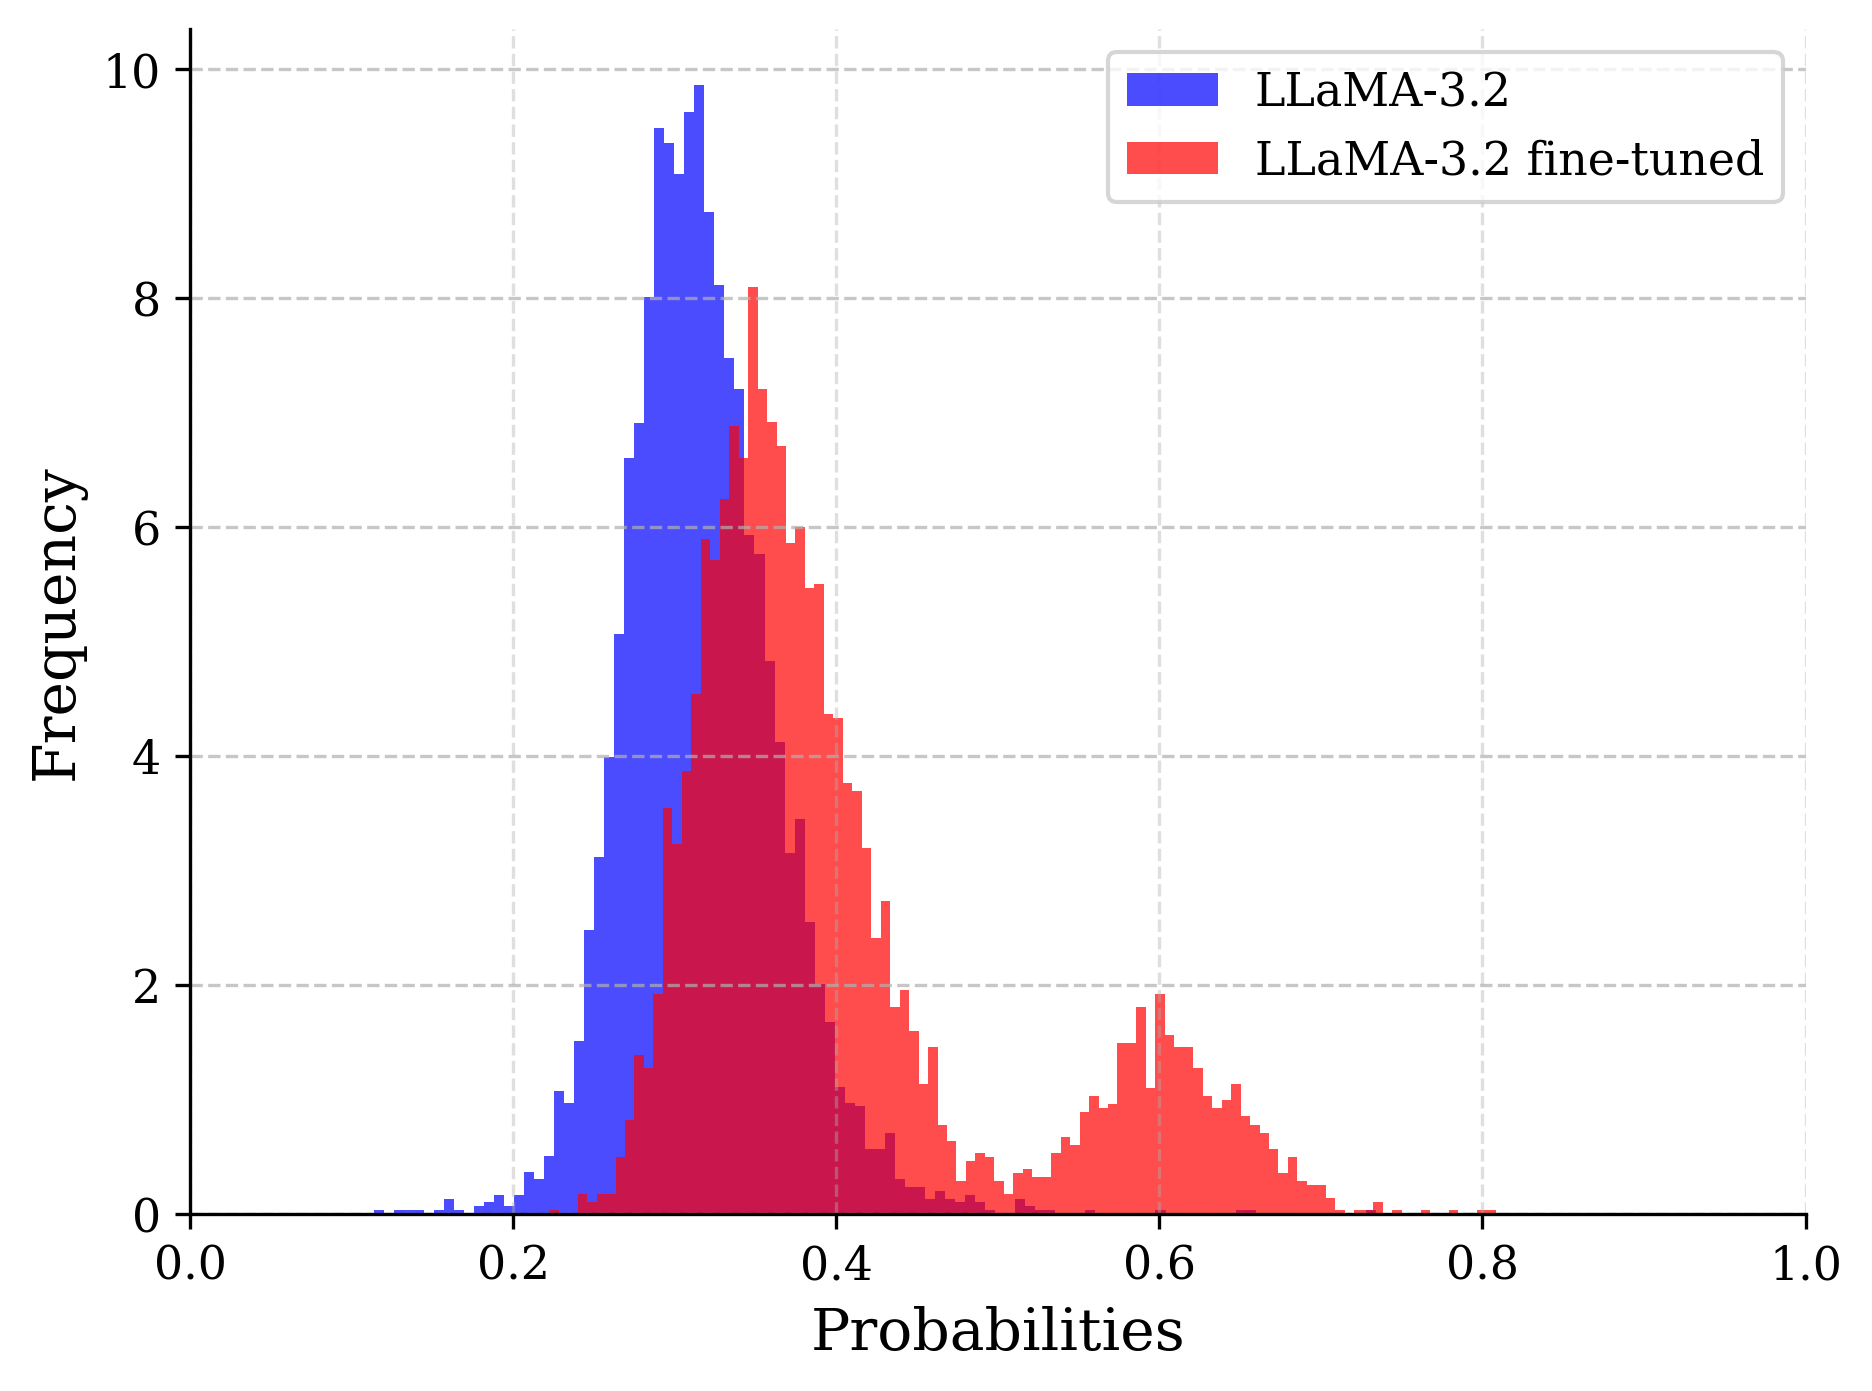

In [9]:
plt.hist(probs[0][0], bins=100, alpha=0.7, density=True, color='blue')
plt.hist(probs[1][0], bins=100, alpha=0.7, density=True, color='red')
plt.xlabel('Probabilities')
plt.ylabel('Frequency')
# plt.title('Probability Distribution of Correct Class on the Generated Dataset')
plt.xlim(0, 1)  # Set x-axis limits to [0, 1]
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.legend(['LLaMA-3.2', 'LLaMA-3.2 fine-tuned'])
plt.show()

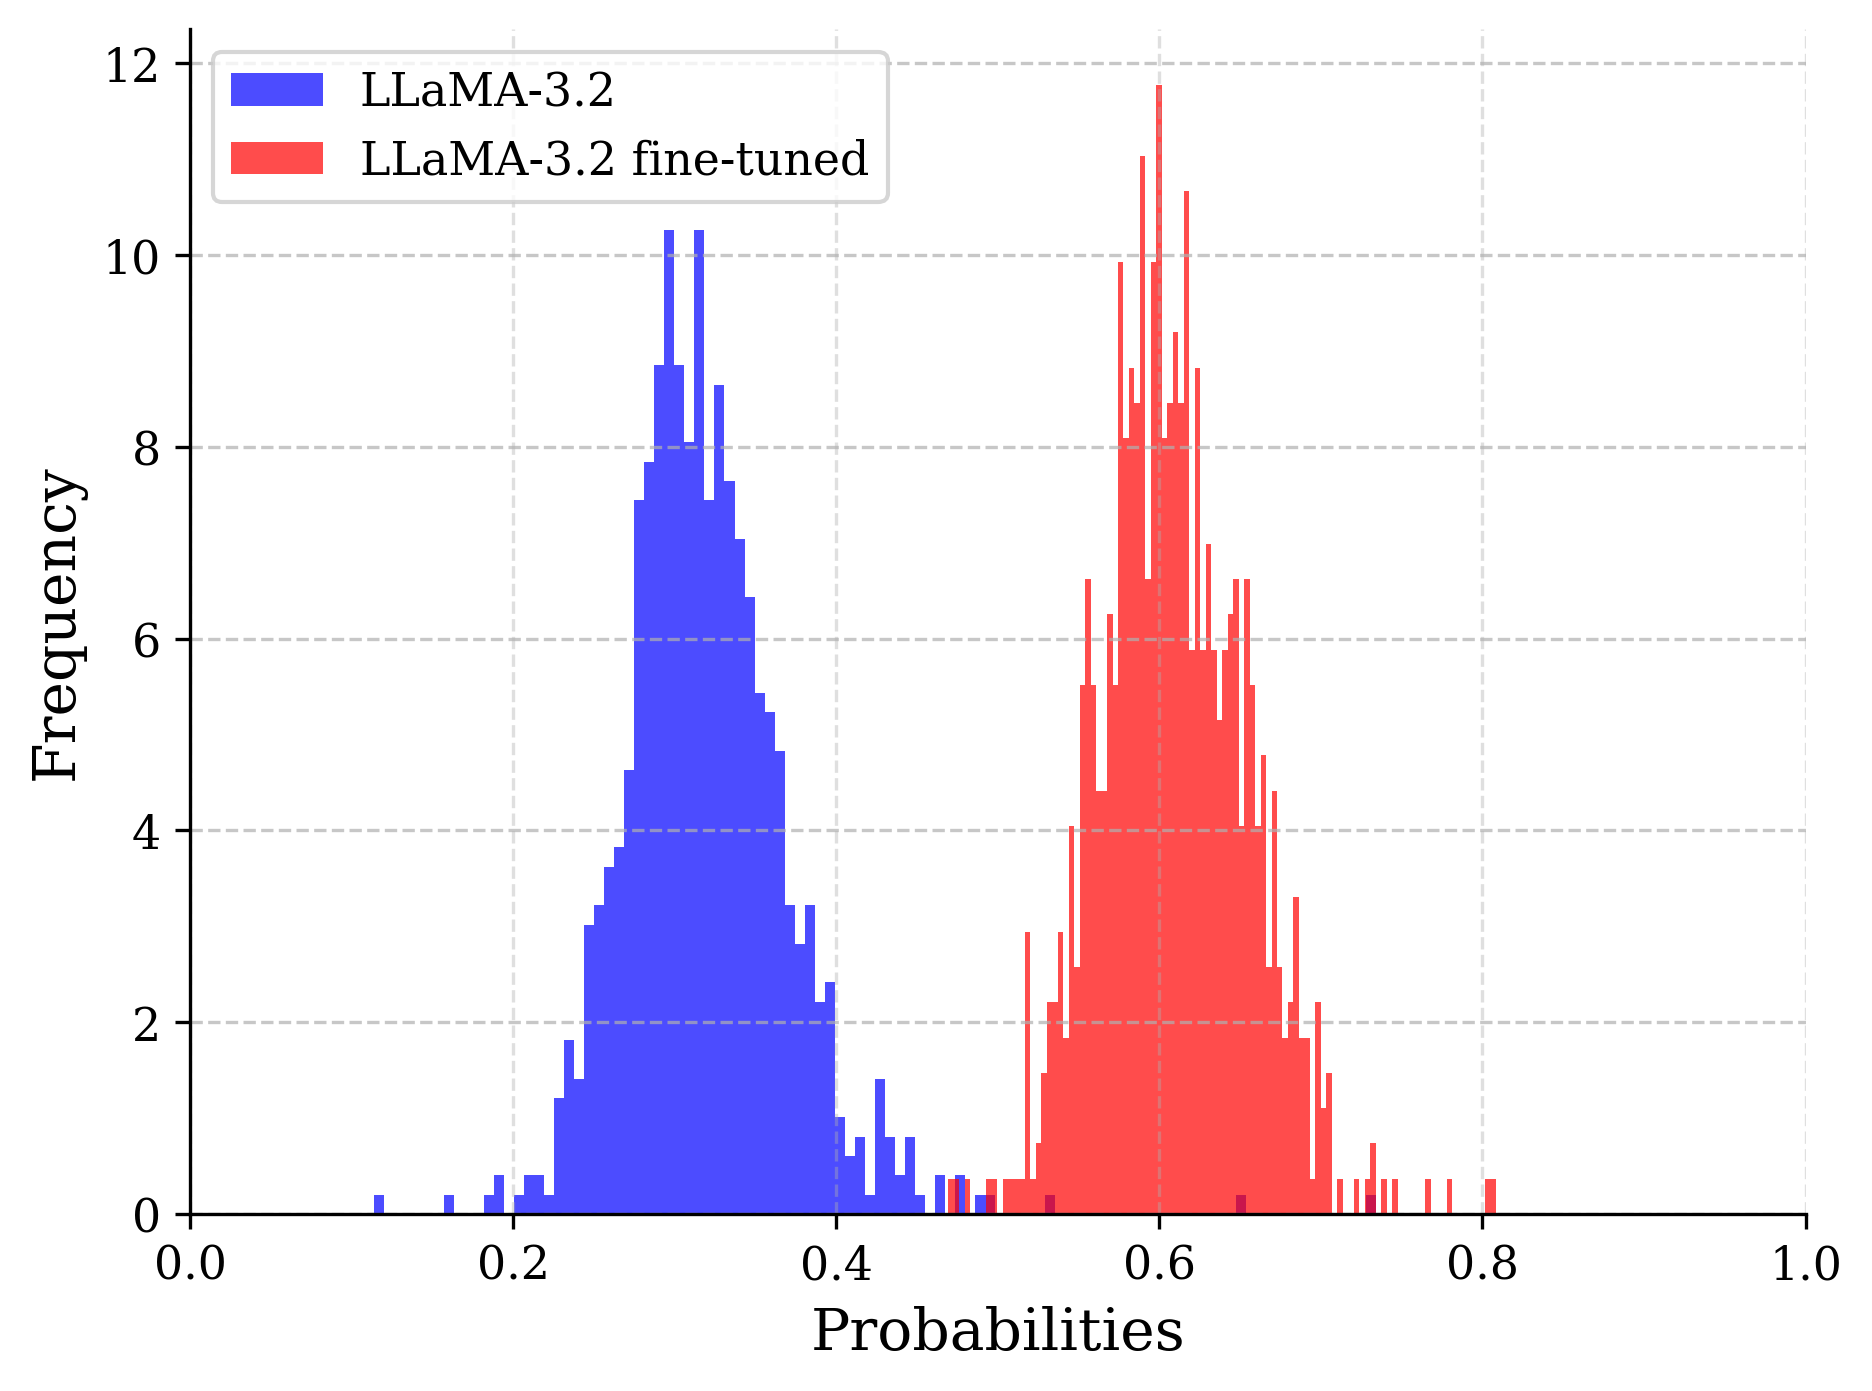

In [10]:
plt.hist(probs[0][1], bins=100, alpha=0.7, density=True, color='blue')
plt.hist(probs[1][1], bins=100, alpha=0.7, density=True, color='red')
plt.xlabel('Probabilities')
plt.ylabel('Frequency')
# plt.title('Probability Distribution of Correct Class on the Generated Dataset')
plt.xlim(0, 1)  # Set x-axis limits to [0, 1]
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.legend(['LLaMA-3.2', 'LLaMA-3.2 fine-tuned'])
plt.show()